dataset shape: (1, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

transient time:  1395
N_v 10


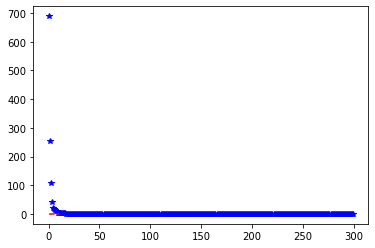

pre_output shape: (301, 10000)
W_out shape: (1, 301)
0.011432958904932865


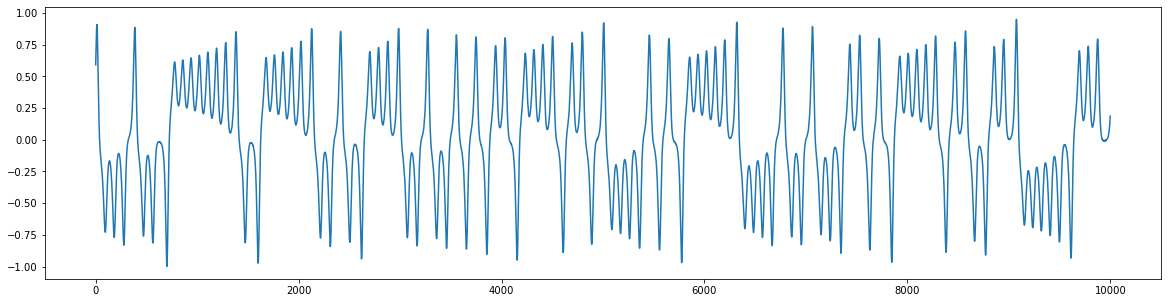

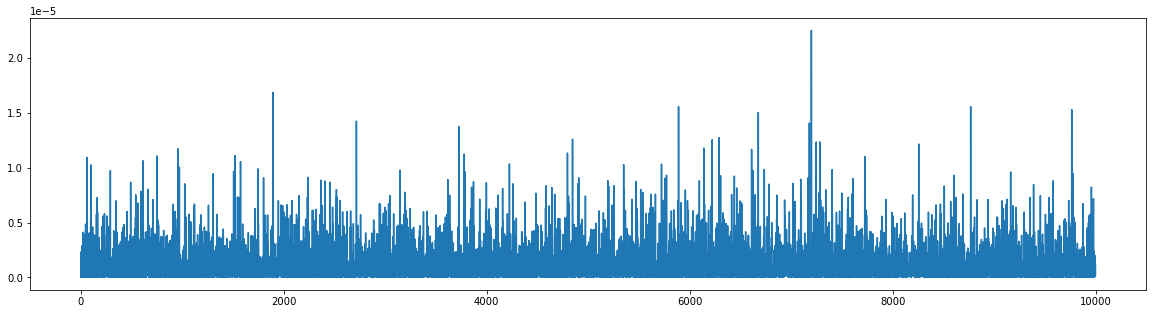

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import random
import scipy.linalg
import seaborn as sns
import time
from tqdm.notebook import tqdm
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
plt.ion()
%matplotlib inline
seed = 42
random.seed(seed) 
np.random.seed(seed)

class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))
        

path = 'result/esn_attn_standalone'
if not os.path.exists(path):
    os.makedirs(path)
    
def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""
    def omega_approx(beta):
        """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
        return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

    def lambda_star(beta):
        """Return lambda star for given beta. Equation (11) from Gavish 2014."""
        return np.sqrt(2 * (beta + 1) + (8 * beta) / 
                   (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma


# system_name = 'Rossler'
# system_name = 'Rabinovich Fabrikant'
system_name = 'Lorenz'
# system_name ='Four-Scroll'

dim = [0]
dim_label='x'
U0 = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T[dim]
U = U0 + np.random.randn(*U0.shape)*1e-3
U = np.atleast_2d(U)
num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 1000
test_start = num_prepare + num_train + num_val
num_test = 5000
print('dataset shape:', U.shape)


inSize = U.shape[0]
outSize = inSize  
resSize = 300
a = 0.1         # leaking rate
K = 1.99          # spectial redius
reg = 1e-6       # regularization coefficient 
input_scaling = 1


# generation of random weights
Win = (np.random.rand(resSize,1+inSize)-0.5) * input_scaling
W = np.random.rand(resSize,resSize)-0.5
largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])
W = W/rhoW*K 
X = np.zeros((resSize,U.shape[1]))

is_transient = True
initial_transients = [np.zeros([resSize,1]), np.ones([resSize,1]), -np.ones([resSize,1])]
x = initial_transients[0]

for t in tqdm(range(U.shape[1])):
    u = U[:,t:t+1]
    x = (1-a) * x + a * np.tanh( Win @ np.vstack((1,u)) + W @ x ) 
    X[:,t:t+1] = x
    
    if is_transient:  # compute distance between states with different initials
        initial_transients[0] = x
        max_dis = 0
        for i in range(1,3):
            xi = initial_transients[i]
            initial_transients[i] = (1-a) * xi + a * np.tanh( Win @ np.vstack((1,u)) + W @ xi )
            diff = initial_transients[i] - initial_transients[0]
            max_dis = max(max_dis, np.sqrt(np.sum(diff**2, axis=0)))
        if max_dis <1e-10:
            is_transient = False
            print('transient time: ', t)

# offline train
U_train = U[:,train_start : train_start + num_train]
X_train = X[:,train_start : train_start + num_train]
Y_train = U[:,train_start + 1 : train_start + num_train + 1]
H = np.vstack((np.ones((1,X_train.shape[1])),X_train))


Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
plt.plot(Diag, 'b*', label='sigular values')

tau = svht(X_train, sv=Diag)
N_v = np.sum(Diag>tau)
N_v = 10
print('N_v',N_v)
MlT, Diag, Mr = Ml.T[:N_v], Diag[:N_v], Mr[:N_v]

plt.plot([0,len(Diag)],[tau,tau], 'r--', label=r'$\sigma$ unknown')
# plt.yscale('log')
plt.show()


Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
print('pre_output shape:', H.shape)
print('W_out shape:', Wout.shape)

plt.figure(figsize=(20,5))
plt.plot(U_train.T)

plt.figure(figsize=(20,5))
sse = np.sum(np.square(Y_train - Wout @ H), axis=0)
plt.plot(sse)
print(np.sum(sse))

  0%|          | 0/5000 [00:00<?, ?it/s]

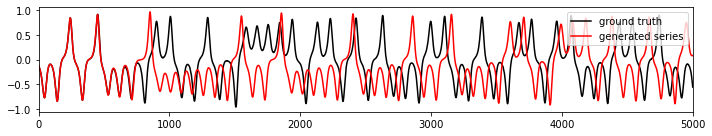

In [75]:
horizon = 5000
Y_gen = []
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + 1]
        X_test = X[:,test_start : test_start + 1]
    else:
        U_test = Y_pred
        X_test = (1 - a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,1)),U_test)) + W @ X_test )
    H = np.vstack((np.ones((1,1)),X_test))
    Y_pred = Wout @ H
    Y_gen.append(Y_pred[:,0])

Y_gen = np.array(Y_gen)
plt.figure(figsize=(10,2))
plt.plot(U[:,test_start+1: test_start + 1+horizon].T, 'k',label='ground truth')
plt.plot(Y_gen, 'r', label='generated series',alpha=1)
plt.legend(loc='upper right')
plt.xlim([0,5000])
plt.tight_layout()
plt.savefig(path+'/ESN-gen-{}-{}.pdf'.format(system_name,dim_label))
plt.show()

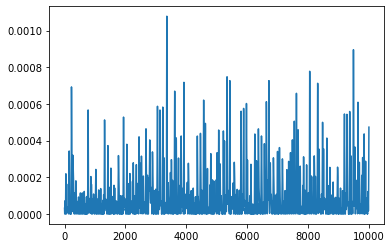

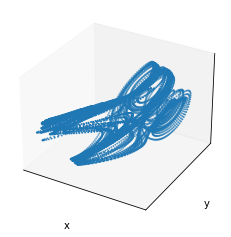

done


In [5]:

def interpolateColor(colorA, colorB, alpha):
    return tuple(np.array(colorA)*(1-alpha) + np.array(colorB)*(alpha))

red = (1,0,0)
pink = (1,0.9,0.9)

# c = (sse - np.min(sse))/(np.max(sse) - np.min(sse))
c = Mr[-1]**2
plt.plot(c)

if len(U_train) == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=90, azim=90)
    # ax.plot(*Y_train, 'k', alpha=0.5)
    ax.scatter(*Y_train, s=1,c=c, cmap='Reds')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xticks([])
    plt.yticks([])
    ax.set_zticks([])
    plt.show()
else:
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')
#     ax.view_init(elev=90, azim=90)

    ax.scatter(*Mr[:3], s=1, cmap='Reds')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xticks([])
    plt.yticks([])
    ax.set_zticks([])
    plt.show()
    

def sample(weights, labels, N_new = None):
    if N_new is None:
        N_new = len(labels)
    
    N = len(labels)
    p = []
    indice = []
    index = int(random.random() * N)
    beta = 0.0  # 轮盘指针
    mw = np.sum(weights)
    while len(indice) <N_new:
        beta += random.random() * 2.0 * mw
        while beta > weights[index]:
            beta -= weights[index]
            index = (index + 1) % N
        if not index in indice:
            p.append(labels[index])
            indice.append(index)
    
    return p, indice

N_c = 100
Cs0, indice = sample(c, (MlT@X_train).T, N_c)
Cs0 = np.array(Cs0)

# print(Cs0.shape, Cs0)
if len(U_train) == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=90, azim=90)
    ax.plot(*Y_train, 'k', alpha=0.6)
    ax.scatter(*Y_train[:,np.array(indice, dtype='int64')], s=10, color='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xticks([])
    plt.yticks([])
    ax.set_zticks([])
    # ax.set_zlabel('z')
    plt.show()

print('done')


In [150]:
# plt.figure()

# Hankel = np.vstack([U0[i:i+10000] for i in range(100)])
# HU, HS, HV = np.linalg.svd(X_train, full_matrices=False)
# Htau = svht(Hankel, sv=HS)
# r = np.sum(HS>Htau)
# _ = plt.plot(HV.T[:,r]**2)

## recursive multistep prediction

  0%|          | 0/100 [00:00<?, ?it/s]

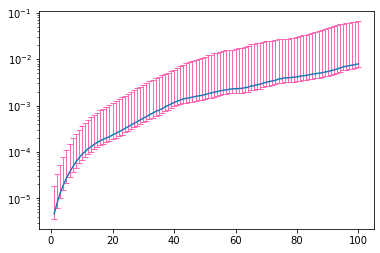

1.152549355936587e-05


In [6]:
horizon = 100
mse1 = []
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        X_test = X[:,test_start : test_start + num_test]
    else:
        U_test = Y_pred
        X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test ) 
    H = np.vstack((np.ones((1,num_test)),X_test))
    Y_pred = Wout @ H
    Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
    mse1.append(np.sum(np.square(Y_pred - Y_true), axis=0))

err_range1 = np.array([np.quantile(mse1, 0.25, axis=1),np.quantile(mse1, 0.75, axis=1)])
plt.errorbar(range(1,horizon+1),np.median(mse1, axis=1), yerr=err_range1,
             ecolor='hotpink', elinewidth=1,ms=5,mfc='wheat',mec='salmon',capsize=3)
plt.yscale('log')
plt.show()
print(np.average(mse1[0]))

In [7]:
horizon = 10000
Y_gen = []
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + 1]
        X_test = X[:,test_start : test_start + 1]
    else:
        U_test = Y_pred
        X_test = (1 - a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,1)),U_test)) + W @ X_test )
    H = np.vstack((np.ones((1,1)),X_test))
    Y_pred = Wout @ H
    Y_gen.append(Y_pred[:,0])
    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [153]:
def pairwise_distances(X, Y):
        D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
        D[D < 0] = 0
        return D
    
from sklearn.cluster import KMeans
def clustering(data, N_c):
    estimator = KMeans(init='k-means++', n_clusters=N_c, n_init=3)
    estimator.fit(data)
    return estimator.cluster_centers_

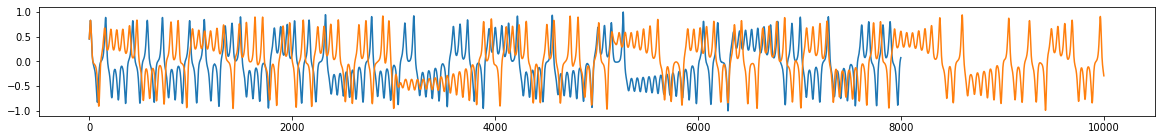

the number of peaks is 123


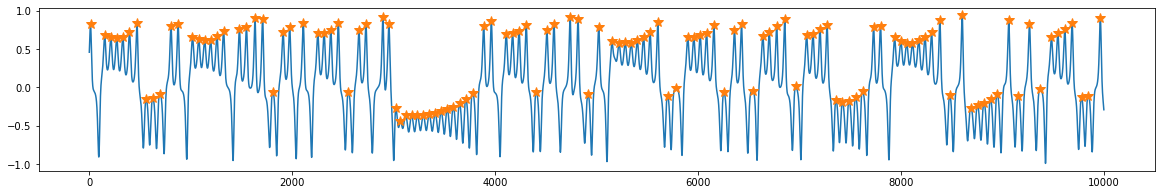

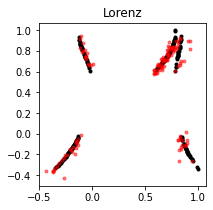

NameError: name 'pairwise_distances' is not defined

In [8]:
Y_gen = np.array(Y_gen)
plt.figure(figsize=(20,2))
plt.plot(U[:,test_start+1: test_start + 1+horizon].T)
plt.plot(Y_gen)
plt.show()

if len(U_train) == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.plot(*Y_gen.T, 'k')
    plt.plot(*U[:,test_start+1: test_start + 1+horizon], 'r', alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
x, y = U0.T[:,:1], Y_gen[:,:1]
x, y = np.squeeze(x),np.squeeze(y)
from scipy import signal
x_peaks, _ = signal.find_peaks(x, distance=5) #distance表极大值点的距离至少大于等于10个水平单位
peaks, _ = signal.find_peaks(y, distance=5) #distance表极大值点的距离至少大于等于10个水平单位

print('the number of peaks is ' + str(len(peaks)))

plt.figure(figsize=(20,3))
plt.plot(y)
plt.plot(peaks, y[peaks],'*',markersize=10)
plt.figure(figsize=(3,3))
plt.title(system_name)
plt.plot(x[x_peaks][:-1], x[x_peaks][1:], '.k')
plt.plot(y[peaks][:-1], y[peaks][1:], '.r', alpha=0.5)
plt.show()

x_ppp = np.array([x[x_peaks][:-1], x[x_peaks][1:]]).T
y_ppp = np.array([y[peaks][:-1], y[peaks][1:]]).T
pd = pairwise_distances(x_ppp, y_ppp)
max(np.max(np.min(pd,axis=0)), np.max(np.min(pd, axis=1)))

# attention by FCM

# SVD

In [155]:
# def col_normalize(x, f=None):
#     if x.shape[0] == 0:
#         return x

#     fx = f(x) if f else x
#     fx_sum = fx.sum(axis=0).reshape([1, fx.shape[1]])
#     return fx / fx_sum

# offline train
with Timer():

    
#     plt.plot(Diag)
#     plt.figure()
#     plt.plot((np.diag(Diag)@ Mr).T)
#     plt.show()

#     Cs3 = clustering((np.diag(Diag)@ Mr).T, N_c)
    Cs3 = Cs0
#     Cs3 = np.random.random([N_c, N_v])
#     okm = OnlineKMeans(N_v, N_c, flag=True, random_init=False)
#     for p in tqdm((MlT@X_train).T):
#         okm.fit(p)
#     Cs3 = okm.centroid

    choices = []
    for beta in tqdm([1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16]):
        S = np.exp(- beta * pairwise_distances(Cs3, (np.diag(Diag)@ Mr).T))
        H = np.vstack((np.ones((1,num_train)), X_train, S))
        Wout3 = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
    
        # validation
        horizon = 10
        mse3 = []
        for h in range(horizon):
            if h == 0:
                U_val = U[:,val_start : val_start + num_val]
                X_val = X[:,val_start : val_start + num_val]
            else:
                U_val = Y_pred
                X_val = (1 - a) * X_val + a * np.tanh( Win @ np.vstack((np.ones((1,num_val)),U_val)) + W @ X_val )
            S = np.exp( - beta* pairwise_distances(Cs3, (MlT @ X_val).T))
            H = np.vstack((np.ones((1,num_val)), X_val, S))
            Y_pred = Wout3 @ H
            Y_true = U[:,val_start+h+1 : val_start + num_val + h+1]
            mse3.append(np.average(np.sum(np.square(Y_pred - Y_true), axis=0)))
        choices.append((mse3[-1],beta, Wout3))
    train_error, beta3, Wout3 = sorted(choices)[0]
    print('pre_output shape:', H.shape)
    print('W_out shape:', Wout3.shape)
    print('train error:', train_error)
    print('beta3:', beta3)


pre_output shape: (1101, 1000)
W_out shape: (3, 1101)
train error: 3.848234931352629e-06
beta3: 0.0625
[time spent: 5.04s]


In [156]:
# test
with Timer():
    horizon = 100
    mse3 = []
    for h in tqdm(range(horizon)):
        if h == 0:
            U_test = U[:,test_start : test_start + num_test]
            X_test = X[:,test_start : test_start + num_test]
        else:
            U_test = Y_pred
            X_test = (1 - a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )
        S = np.exp( - beta3 * pairwise_distances(Cs3, ( MlT @ X_test).T))
        H = np.vstack((np.ones((1,num_test)), X_test, S))
        Y_pred = Wout3 @ H
        Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
        mse3.append(np.sum(np.square(Y_pred - Y_true), axis=0))
# 


[time spent: 21.05s]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

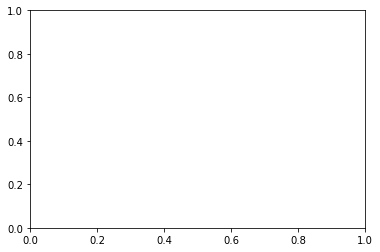

In [160]:
plt.errorbar(range(1,horizon+1),np.median(mse1, axis=1), yerr=err_range1,
             ecolor='hotpink', elinewidth=1,ms=5,mfc='wheat',mec='salmon',capsize=3)

err_range3 = np.array([np.quantile(mse3, 0.25, axis=1),np.quantile(mse3, 0.75, axis=1)])
plt.errorbar(range(1,horizon+1),np.median(mse3, axis=1), yerr=err_range3, color='black',
             ecolor='red', elinewidth=1,ms=5,mfc='wheat',mec='salmon',capsize=3)
# plt.yscale('log')
plt.show()


plt.figure()
plt.plot(range(1,horizon+1),np.average(mse1, axis=1), color='hotpink')
plt.plot(range(1,horizon+1),np.average(mse3, axis=1), color='red')

plt.show()
print(np.average(mse3[0]))

In [158]:
horizon = 10000
Y_gen = []
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + 1]
        X_test = X[:,test_start : test_start + 1]
    else:
        U_test = Y_pred
        X_test = (1 - a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,1)),U_test)) + W @ X_test )
    S = np.exp( - beta3 * pairwise_distances(Cs3, (MlT @ X_test).T))
    H = np.vstack((np.ones((1,1)), X_test, S))
    Y_pred = Wout3 @ H
    Y_gen.append(Y_pred[:,0])



the number of peaks is 116


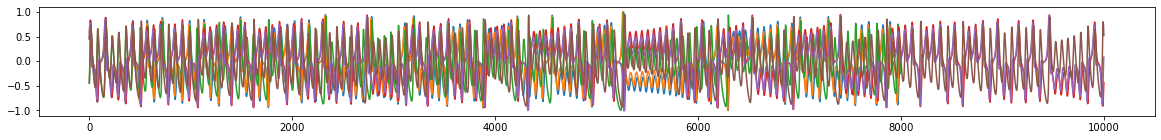

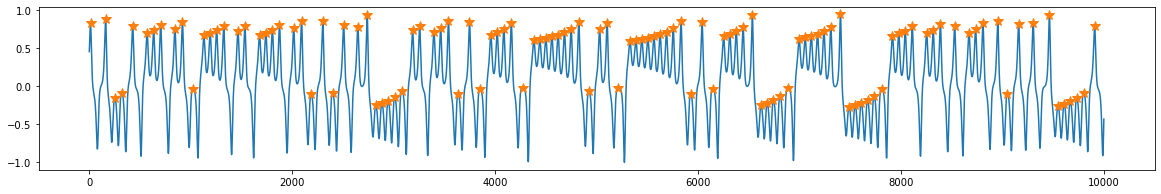

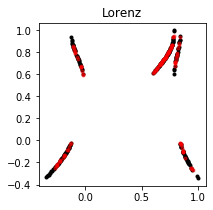

0.013014954740136031

In [161]:
Y_gen = np.array(Y_gen)
plt.figure(figsize=(20,2))
plt.plot(U[:,test_start+1: test_start + 1+horizon].T)
plt.plot(Y_gen)

x, y = U0.T[:,:1], Y_gen[:,:1]
x, y = np.squeeze(x),np.squeeze(y)
from scipy import signal
x_peaks, _ = signal.find_peaks(x, distance=5) #distance表极大值点的距离至少大于等于10个水平单位
peaks, _ = signal.find_peaks(y, distance=5) #distance表极大值点的距离至少大于等于10个水平单位

print('the number of peaks is ' + str(len(peaks)))

plt.figure(figsize=(20,3))
plt.plot(y)
plt.plot(peaks, y[peaks],'*',markersize=10)
plt.figure(figsize=(3,3))
plt.title(system_name)
plt.plot(x[x_peaks][:-1], x[x_peaks][1:], '.k')
plt.plot(y[peaks][:-1], y[peaks][1:], '.r', alpha=0.5)
plt.show()

if len(X_train) == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.plot(*Y_gen.T, 'k')
    plt.plot(*U[:,test_start+1: test_start + 1+horizon], 'r', alpha=0.6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

x_ppp = np.array([x[x_peaks][:-1], x[x_peaks][1:]]).T
y_ppp = np.array([y[peaks][:-1], y[peaks][1:]]).T
pd = pairwise_distances(x_ppp, y_ppp)
max(np.max(np.min(pd,axis=0)), np.max(np.min(pd, axis=1)))

# one cell

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import random
import scipy.linalg
import seaborn as sns
import time
from tqdm.notebook import tqdm
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
from skfuzzy.cluster import cmeans



class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))
        
def pairwise_distances(X, Y):
    D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
    D[D < 0] = 0
    return D
    

def clustering(data, N_c):
    estimator = KMeans(init='k-means++', n_clusters=N_c, n_init=3)
    estimator.fit(data)
    return estimator.cluster_centers_

path = 'result/esn_attn_standalone'
if not os.path.exists(path):
    os.makedirs(path)
    

# system_name = 'rossler1d'
# system_name = 'rabinovich_fabrikant1d'
# system_name = 'lorentz1d'
# system_name = 'chua1d'
for system_name in [
#     'Lorenz',
    'Rossler',
    'Rabinovich Fabrikant',
    'Four-Scroll'
]:

    U = np.loadtxt('dataset/'+system_name+'.csv', delimiter=',').T[0:1]
    U += np.random.randn(*U.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    val_start = num_prepare + num_train
    num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('dataset shape:', U.shape)

    U_train = U[:,train_start : train_start + num_train]
    Y_train = U[:,train_start + 1 : train_start + num_train + 1]

    inSize = U.shape[0]
    outSize = inSize  
    resSize = 1000
    a = 0.9             # leaking rate
    K = 0.99            # spectial redius
    reg = 1e-6         # regularization coefficient 
    input_scaling = 1
    N_c = 100
    N_v = 10
    horizon = 100

    for seed in tqdm(range(20)):

        random.seed(seed) 
        np.random.seed(seed)

        Win = (np.random.rand(resSize,1+inSize)-0.5) * input_scaling
        W = np.random.rand(resSize,resSize)-0.5
        largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
        rhoW = np.sqrt(largest_eigvals[0])
        W = W/rhoW*(K-1+a)/a 
        X = np.zeros((resSize,U.shape[1]))

        x = np.zeros([resSize,1])
        for t in range(U.shape[1]):
            u = U[:,t:t+1]
            x = (1-a) * x + a * np.tanh( Win @ np.vstack((1,u)) + W @ x ) 
            X[:,t:t+1] = x

        # train1
        X_train = X[:,train_start : train_start + num_train]
        H = np.vstack((np.ones((1,num_train)),U_train,X_train))
        Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

        # test1
        mse = []
        for h in range(horizon):
            if h == 0:
                U_test = U[:,test_start : test_start + num_test]
                X_test = X[:,test_start : test_start + num_test]
            else:
                U_test = Y_pred
                X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test ) 
            H = np.vstack((np.ones((1,num_test)),U_test,X_test))
            Y_pred = Wout @ H
            Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
            mse.append(np.average(np.sum(np.square(Y_pred - Y_true), axis=0)))

        with open(os.path.join(path,'{}{}d_esn_multistep_numtrain_{}_ressize_{}_ncenters_{}.csv'\
                               .format(system_name, inSize,num_train, resSize, N_c)), 'a') as file:
            file.write(','.join([str(i) for i in mse]) + '\n')



#         # train2
        Cs2 = clustering(X_train.T, N_c)
        choices = []
        for beta in [1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16]:
            S = np.exp(- beta * pairwise_distances(Cs2, X_train.T))
            H = np.vstack((np.ones((1,num_train)),U_train,X_train, S))
            Wout2 = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

            # validation
            mse2 = []
            for h in range(horizon):
                if h == 0:
                    U_val = U[:,val_start : val_start + num_val]
                    X_val = X[:,val_start : val_start + num_val]
                else:
                    U_val = Y_pred
                    X_val = (1 - a) * X_val + a * np.tanh( Win @ np.vstack((np.ones((1,num_val)),U_val)) + W @ X_val )
                S = np.exp( - beta* pairwise_distances(Cs2, X_val.T))
                H = np.vstack((np.ones((1,num_val)), U_val, X_val, S))
                Y_pred = Wout2 @ H
                Y_true = U[:,val_start+h+1 : val_start + num_val + h+1]
                mse2.append(np.average(np.sum(np.square(Y_pred - Y_true), axis=0)))

            choices.append((mse2[-1],beta, Wout2))
        _, beta2, Wout2 = sorted(choices)[0]

        # test2
        mse2 = []
        for h in range(horizon):
            if h == 0:
                U_test = U[:,test_start : test_start + num_test]
                X_test = X[:,test_start : test_start + num_test]
            else:
                U_test = Y_pred
                X_test = (1 - a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )
            S_test = np.exp( - beta2 * pairwise_distances(Cs2, X_test.T))
            H2 = np.vstack((np.ones((1,num_test)), U_test, X_test, S_test))
            Y_pred = Wout2 @ H2
            Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
            mse2.append(np.average(np.sum(np.square(Y_pred - Y_true), axis=0)))

        with open(os.path.join(path, '{}{}d_esn_attn_multistep_numtrain_{}_ressize_{}_ncenters_{}.csv'\
                               .format(system_name, inSize,num_train, resSize, N_c)), 'a') as file:
            file.write(','.join([str(i) for i in mse2]) + '\n')

        # train3
        Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)
        MlT, Diag, Mr = Ml.T[:N_v], Diag[:N_v], Mr[:N_v]
        Cs3 = clustering((np.diag(Diag)@Mr).T, N_c)
        choices = []
        for beta in [1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16]:
            S = np.exp(- beta * pairwise_distances(Cs3, (np.diag(Diag)@Mr).T))
            H = np.vstack((np.ones((1,num_train)),U_train,X_train, S))
            Wout3 = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

            # validation
            mse3 = []
            for h in range(horizon):
                if h == 0:
                    U_val = U[:,val_start : val_start + num_val]
                    X_val = X[:,val_start : val_start + num_val]
                else:
                    U_val = Y_pred
                    X_val = (1 - a) * X_val + a * np.tanh( Win @ np.vstack((np.ones((1,num_val)),U_val)) + W @ X_val )
                S = np.exp( - beta* pairwise_distances(Cs3, ( MlT @ X_val).T))
                H = np.vstack((np.ones((1,num_val)), U_val, X_val, S))
                Y_pred = Wout3 @ H
                Y_true = U[:,val_start+h+1 : val_start + num_val + h+1]
                mse3.append(np.average(np.sum(np.square(Y_pred - Y_true), axis=0)))
            choices.append((mse3[-1],beta, Wout3))
        _, beta3, Wout3 = sorted(choices)[0]

        # test3
        mse3 = []
        for h in range(horizon):
            if h == 0:
                U_test = U[:,test_start : test_start + num_test]
                X_test = X[:,test_start : test_start + num_test]
            else:
                U_test = Y_pred
                X_test = (1 - a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )
            S = np.exp( - beta3 * pairwise_distances(Cs3, (MlT @ X_test).T))
            H = np.vstack((np.ones((1,num_test)), U_test, X_test, S))
            Y_pred = Wout3 @ H
            Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
            mse3.append(np.average(np.sum(np.square(Y_pred - Y_true), axis=0)))


        with open(os.path.join(path, '{}{}d_esn_attn_svd_multistep_numtrain_{}_ressize_{}_ncenters_{}.csv'\
                               .format(system_name, inSize,num_train, resSize, N_c)), 'a') as file:
            file.write(','.join([str(i) for i in mse3]) + '\n')


dataset shape: (1, 20000)



dataset shape: (1, 20000)



dataset shape: (1, 20000)



dataset shape: (1, 20000)


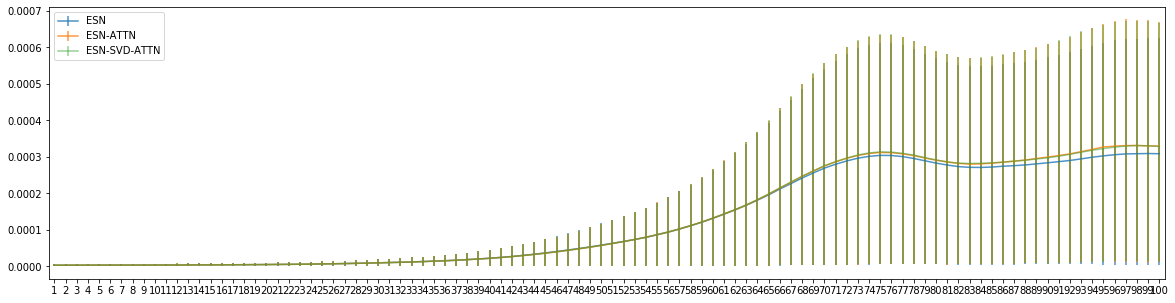

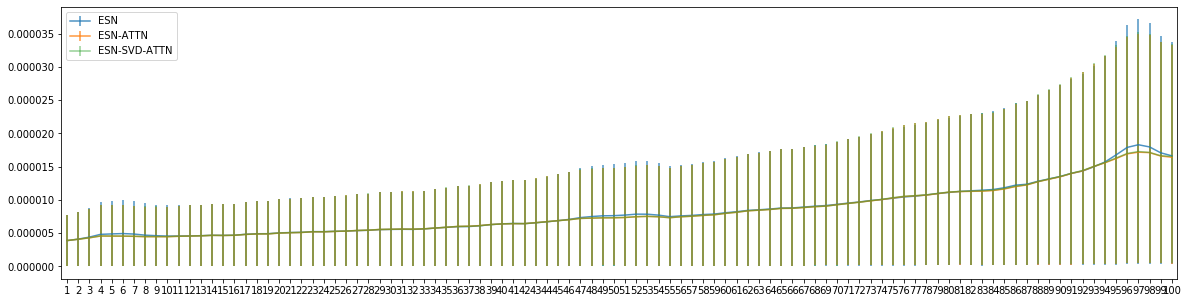

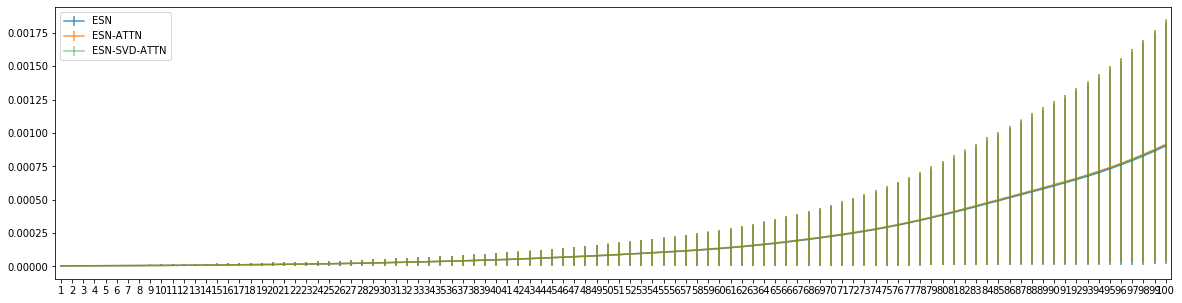

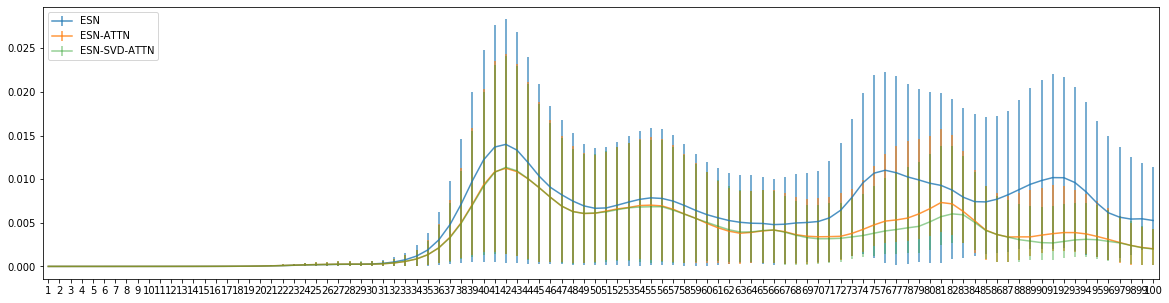

In [82]:
for system_name in [
    'Lorenz',
    'Rossler',
    'Rabinovich Fabrikant',
    'Four-Scroll'
]:
    df1 = pd.read_csv(path+'/'+system_name+'_esn_multistep.csv', header=None)
    df2 = pd.read_csv(path+'/'+system_name+'_esn_attn_multistep.csv', header=None)
    df3 = pd.read_csv(path+'/'+system_name+'_esn_attn_svd_multistep.csv', header=None)

    plt.figure(figsize=(20,5))
    yerr1 = np.array([list(df1.quantile(0.25)), list(df1.quantile(0.75))]).reshape((1,2,100))
    df1.median().plot( yerr=yerr1, alpha=0.8, label='ESN')
    yerr2 = np.array([list(df2.quantile(0.25)), list(df2.quantile(0.75))]).reshape((1,2,100))
    df2.median().plot( yerr=yerr2, alpha=0.8, label='ESN-ATTN')
    yerr3 = np.array([list(df3.quantile(0.25)), list(df3.quantile(0.75))]).reshape((1,2,100))
    df3.median().plot(yerr=yerr3, alpha=0.5, label='ESN-SVD-ATTN')
    plt.xticks([i for i in range(100)], [i for i in range(1,101)])
    plt.xlim([-0.5,99.5])
#     plt.yscale('log') 
    plt.legend(loc='upper left')